,date,game_id,home_team,home_team_id,away_team,away_team_id,home_goals,away_goals,result
0,2017-08-04,2500691,Monaco,3780,Toulouse,19830,3,2,H
1,2017-08-05,2500694,Saint-Étienne,3775,Nice,3782,1,0,H
2,2017-08-05,2500688,Olympique Lyonnais,3766,Strasbourg,3779,4,0,H
3,2017-08-05,2500690,Metz,3777,Guingamp,3785,1,3,A
4,2017-08-05,2500693,PSG,3767,Amiens SC,3789,2,0,H
...,...,...,...,...,...,...,...,...,...
1821,2018-05-20,2576331,Udinese,3166,Bologna,3163,1,0,H
1822,2018-05-20,2576332,Napoli,3197,Crotone,3187,2,1,H
1823,2018-05-20,2576333,Milan,3157,Fiorentina,3176,5,1,H
1824,2018-05-20,2565922,Barcelona,676,Real Sociedad,687,1,0,H


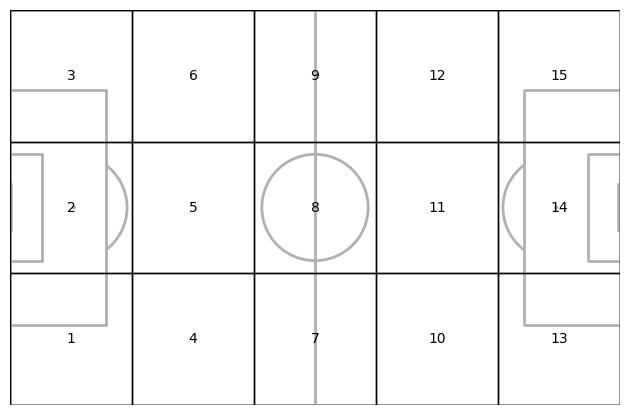

,game_id,team_id,period_id,time_seconds,start_x,start_y,end_x,end_y,type_name,result_name
0,2500089,1659,1,2.763597,52.50,34.00,63.00,30.60,pass,success
1,2500089,1659,1,4.761353,63.00,30.60,64.05,10.20,pass,success
2,2500089,1659,1,5.533097,64.05,10.20,72.45,20.40,pass,success
3,2500089,1659,1,7.707561,72.45,20.40,35.70,19.04,pass,success
4,2500089,1659,1,11.614943,35.70,19.04,30.45,12.24,pass,success
...,...,...,...,...,...,...,...,...,...,...
2319206,2565557,696,2,2836.932876,8.40,60.52,26.25,36.72,dribble,success
2319207,2565557,696,2,2839.889917,26.25,36.72,11.55,65.28,pass,success
2319208,2565557,696,2,2845.944625,11.55,65.28,8.40,62.56,take_on,fail
2319209,2565557,696,2,2849.922762,7.35,63.24,7.35,63.24,foul,success


In [88]:
from tqdm import tqdm

def map_to_segment(x, y, flip_x=False):
    if flip_x:
        x = 105 - x

    for i, row in segments_df.iterrows():
        if row['x_bin_start'] <= x <= row['x_bin_end'] and row['y_bin_start'] <= y <= row['y_bin_end']:
            return row['segment']
        # if period_id == 2 -> mirrow the x-axis
        
    return None

for index, row in tqdm(actions.iterrows(), total=actions.shape[0], desc="Mapping actions"):
    actions.loc[index, 'start_segment'] = map_to_segment(row['start_x'], row['start_y'], flip_x=True)
    actions.loc[index, 'end_segment'] = map_to_segment(row['end_x'], row['end_y'], flip_x=True)


actions['start_segment'] = actions['start_segment'].astype(int)
actions['end_segment'] = actions['end_segment'].astype(int)

Mapping actions: 100%|██████████| 2319211/2319211 [13:38<00:00, 2832.73it/s]


In [98]:
actions

,game_id,team_id,period_id,time_seconds,start_x,start_y,end_x,end_y,type_name,result_name,start_segment,end_segment
0,2500089,1659,1,2.763597,52.50,34.00,63.00,30.60,pass,success,8,5
1,2500089,1659,1,4.761353,63.00,30.60,64.05,10.20,pass,success,5,4
2,2500089,1659,1,5.533097,64.05,10.20,72.45,20.40,pass,success,4,4
3,2500089,1659,1,7.707561,72.45,20.40,35.70,19.04,pass,success,4,10
4,2500089,1659,1,11.614943,35.70,19.04,30.45,12.24,pass,success,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...
2319206,2565557,696,2,2836.932876,8.40,60.52,26.25,36.72,dribble,success,15,11
2319207,2565557,696,2,2839.889917,26.25,36.72,11.55,65.28,pass,success,11,15
2319208,2565557,696,2,2845.944625,11.55,65.28,8.40,62.56,take_on,fail,15,15
2319209,2565557,696,2,2849.922762,7.35,63.24,7.35,63.24,foul,success,15,15


In [100]:
from tqdm import tqdm
import pandas as pd
import networkx as nx
from itertools import product

# df = pd.read_csv('./actions_data/actions_processed.csv')
df = actions.copy()
ball_movements = ['pass', 'cross', 'throw_in', 'goalkick', 'freeckick_crossed', 'freekick_short', 'goal_kick']
attack_moves = ['shot', 'shot_freekick', 'shot_penalty']
defensive_moves = ['interception', 'tackle', 'clearance', 'keeper_save', 'keeper_claim', 'keeper_punch', 'keeper_pick_up', 'keeper_sweeper', 'keeper_success']
graph_df = pd.DataFrame()

game_ids = df['game_id'].unique()

for game in tqdm(game_ids, desc="Games Progress"):
     teams = df[df['game_id'] == game]['team_id'].unique()
     for team in teams:
          team_df = df[(df['game_id'] == game) & (df['team_id'] == team)]
          acts = team_df[team_df['type_name'].isin(ball_movements) & (team_df['result_name'] == 'success')]
          
          G = nx.DiGraph()

          for _, row in acts.iterrows():
               player = row['start_segment']
               recipient = row['end_segment']

               if G.has_edge(player, recipient):
                    G[player][recipient]['weight'] += 1
               else:
                    G.add_edge(player, recipient, weight=1)
          
          for u, v in product(segments_df['segment'], segments_df['segment']):
               if not G.has_edge(u, v):
                    G.add_edge(u, v, weight=0)

          attack_actions = team_df[(team_df['type_name'].isin(attack_moves))]
          attack_G = nx.DiGraph()
          
          for _, row in attack_actions.iterrows():
               player = row['start_segment']
               recipient = row['end_segment']

               if attack_G.has_edge(player, recipient):
                    attack_G[player][recipient]['weight'] += 1
               else:
                    attack_G.add_edge(player, recipient, weight=1)

          for u, v in product(segments_df['segment'], segments_df['segment']):
               if not attack_G.has_edge(u, v):
                    attack_G.add_edge(u, v, weight=0)

          graph_df = pd.concat([graph_df, pd.DataFrame({'game_id':[game] , 'team': [team], 'ball_movements_graph': [G], 'attack_graph': [attack_G]})])

graph_df

Games Progress: 100%|██████████| 1826/1826 [00:38<00:00, 47.48it/s]


,game_id,team,ball_movements_graph,attack_graph
0,2500089,1659,"(8, 5, 4, 10, 13, 12, 9, 7, 3, 2, 6, 11, 1, 15...","(14, 13, 11, 15, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9..."
0,2500089,1646,"(6, 9, 2, 5, 10, 4, 7, 3, 13, 12, 11, 8, 1, 14...","(11, 14, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12..."
0,2500090,1628,"(8, 7, 4, 5, 9, 12, 2, 3, 6, 13, 10, 15, 11, 1...","(11, 14, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13..."
0,2500090,1627,"(12, 8, 10, 7, 11, 15, 6, 2, 5, 3, 4, 13, 14, ...","(11, 14, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13..."
0,2500091,1673,"(8, 5, 6, 10, 7, 4, 9, 2, 11, 14, 12, 15, 3, 1...","(14, 11, 10, 13, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9..."
...,...,...,...,...
0,2565549,692,"(9, 12, 4, 8, 5, 6, 2, 10, 1, 7, 11, 15, 13, 1...","(15, 14, 13, 10, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9..."
0,2565556,674,"(8, 6, 5, 4, 10, 11, 1, 12, 2, 7, 9, 15, 14, 1...","(14, 12, 15, 13, 10, 11, 1, 2, 3, 4, 5, 6, 7, ..."
0,2565556,714,"(2, 1, 4, 5, 6, 9, 8, 7, 10, 11, 12, 15, 3, 14...","(14, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13..."
0,2565557,696,"(8, 5, 10, 4, 6, 7, 3, 9, 2, 12, 11, 15, 14, 1...","(15, 14, 11, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10..."


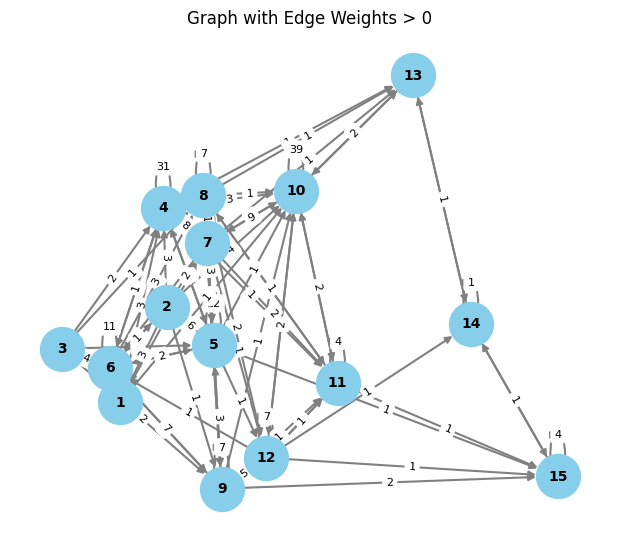

In [101]:
G = graph_df.iloc[0]['ball_movements_graph']

edges_to_draw = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > 0]

# Create a new graph with only filtered edges
G_filtered = G.edge_subgraph(edges_to_draw)

# Position nodes using spring layout
pos = nx.spring_layout(G_filtered)

# Draw the graph
plt.figure(figsize=(6, 5))
nx.draw(G_filtered, pos, with_labels=True, font_weight='bold', node_size=1000,
        node_color='skyblue', font_size=10, edge_color='gray',
        width=1.5, arrows=True, arrowstyle='-|>')

# Draw edge labels (weights)
edge_labels = nx.get_edge_attributes(G_filtered, 'weight')
nx.draw_networkx_edge_labels(G_filtered, pos, edge_labels=edge_labels, font_size=8)

plt.title("Graph with Edge Weights > 0")
plt.show()

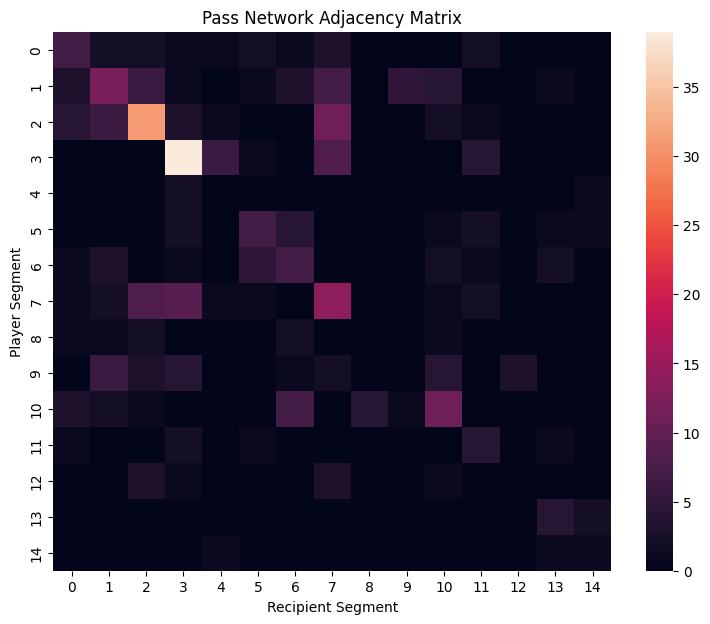

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

adj = nx.adjacency_matrix(G).todense()

plt.figure(figsize=(9, 7))
sns.heatmap(adj, fmt='d')
plt.xlabel('Recipient Segment')
plt.ylabel('Player Segment')
plt.title('Pass Network Adjacency Matrix')
plt.show()

In [110]:
matches = pd.merge(matches, graph_df, left_on=['game_id', 'home_team_id'], right_on=['game_id', 'team'], how='left')
matches.rename(columns={'ball_movements_graph': 'home_team_pass_graph', 'attack_graph': 'home_team_attack_graph'}, inplace=True)

matches = pd.merge(matches, graph_df, left_on=['game_id', 'away_team_id'], right_on=['game_id', 'team'], how='left')
matches.rename(columns={'ball_movements_graph': 'away_team_pass_graph', 'attack_graph': 'away_team_attack_graph'}, inplace=True)

matches = matches[['date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'result', 'home_team_pass_graph', 'away_team_pass_graph', 'home_team_attack_graph', 'away_team_attack_graph']]
matches

,date,home_team,away_team,home_goals,away_goals,result,home_team_pass_graph,away_team_pass_graph,home_team_attack_graph,away_team_attack_graph
0,2017-08-04,Monaco,Toulouse,3,2,H,"(10, 4, 7, 2, 12, 15, 11, 14, 13, 1, 6, 9, 8, ...","(8, 6, 5, 4, 3, 2, 7, 10, 11, 12, 13, 14, 9, 1...","(14, 13, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12...","(13, 14, 15, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10..."
1,2017-08-05,Saint-Étienne,Nice,1,0,H,"(8, 5, 6, 2, 1, 4, 7, 10, 9, 11, 13, 12, 3, 15...","(6, 9, 2, 4, 5, 12, 8, 11, 7, 15, 14, 3, 10, 1...","(13, 14, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12...","(14, 15, 10, 11, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9..."
2,2017-08-05,Olympique Lyonnais,Strasbourg,4,0,H,"(4, 7, 10, 12, 9, 5, 8, 2, 6, 15, 13, 14, 11, ...","(8, 6, 9, 4, 11, 7, 5, 10, 12, 15, 3, 2, 1, 13...","(14, 11, 15, 13, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9...","(14, 12, 15, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11..."
3,2017-08-05,Metz,Guingamp,1,3,A,"(8, 5, 10, 7, 4, 6, 9, 12, 13, 2, 11, 15, 1, 3...","(3, 9, 5, 8, 6, 7, 10, 14, 4, 1, 2, 12, 13, 11...","(14, 11, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13...","(14, 11, 13, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10..."
4,2017-08-05,PSG,Amiens SC,2,0,H,"(3, 9, 6, 5, 7, 4, 2, 8, 12, 15, 11, 14, 10, 1...","(8, 6, 5, 7, 4, 12, 2, 11, 9, 10, 13, 15, 1, 3...","(15, 14, 11, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","(11, 14, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12..."
...,...,...,...,...,...,...,...,...,...,...
1821,2018-05-20,Udinese,Bologna,1,0,H,"(4, 5, 12, 7, 8, 3, 6, 9, 10, 11, 2, 1, 14, 13...","(8, 5, 4, 6, 9, 12, 7, 13, 10, 11, 14, 2, 15, ...","(9, 14, 15, 11, 10, 13, 1, 2, 3, 4, 5, 6, 7, 8...","(14, 15, 11, 10, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9..."
1822,2018-05-20,Napoli,Crotone,2,1,H,"(5, 9, 12, 7, 8, 1, 4, 2, 6, 3, 13, 10, 15, 11...","(5, 8, 12, 6, 11, 9, 4, 2, 7, 10, 14, 3, 15, 1...","(12, 14, 10, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13...","(14, 15, 12, 11, 10, 13, 1, 2, 3, 4, 5, 6, 7, ..."
1823,2018-05-20,Milan,Fiorentina,5,1,H,"(6, 4, 2, 1, 5, 9, 12, 11, 7, 8, 10, 3, 15, 14...","(8, 5, 10, 2, 4, 6, 7, 1, 9, 12, 3, 11, 14, 13...","(14, 11, 13, 15, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9...","(14, 15, 11, 13, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9..."
1824,2018-05-20,Barcelona,Real Sociedad,1,0,H,"(4, 2, 7, 1, 8, 12, 11, 6, 10, 5, 15, 3, 9, 13...","(8, 4, 12, 5, 7, 6, 2, 3, 9, 15, 14, 10, 11, 1...","(10, 14, 13, 11, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9...","(14, 12, 11, 10, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9..."


In [269]:
matches.sort_values(by='date', ascending=True, inplace=True)

matches['home_team_prev_mv_graph_1'] = matches.groupby('home_team')['home_team_pass_graph'].shift(1)
matches['away_team_prev_mv_graph_1'] = matches.groupby('away_team')['away_team_pass_graph'].shift(1)

matches['home_team_prev_attack_graph_1'] = matches.groupby('home_team')['home_team_attack_graph'].shift(1)
matches['away_team_prev_attack_graph_1'] = matches.groupby('away_team')['away_team_attack_graph'].shift(1)

matches['home_team_prev_mv_graph_2'] = matches.groupby('home_team')['home_team_pass_graph'].shift(2)
matches['away_team_prev_mv_graph_2'] = matches.groupby('away_team')['away_team_pass_graph'].shift(2)

matches['home_team_prev_attack_graph_2'] = matches.groupby('home_team')['home_team_attack_graph'].shift(2)
matches['away_team_prev_attack_graph_2'] = matches.groupby('away_team')['away_team_attack_graph'].shift(2)

matches['home_team_prev_mv_graph_3'] = matches.groupby('home_team')['home_team_pass_graph'].shift(3)
matches['away_team_prev_mv_graph_3'] = matches.groupby('away_team')['away_team_pass_graph'].shift(3)

matches['home_team_prev_attack_graph_3'] = matches.groupby('home_team')['home_team_attack_graph'].shift(3)
matches['away_team_prev_attack_graph_3'] = matches.groupby('away_team')['away_team_attack_graph'].shift(3)

matches = matches.dropna()

# invert the graph of the away team

def invert_graph(G):
     G_inv = nx.DiGraph()
     for u, v, d in G.edges(data=True):
          G_inv.add_edge(v, u, weight=d['weight'])
     return G_inv

# matches['away_team_prev_mv_graph_1'] = matches['away_team_prev_mv_graph_1'].apply(invert_graph)
# matches['away_team_prev_attack_graph_1'] = matches['away_team_prev_attack_graph_1'].apply(invert_graph)

# matches['away_team_prev_mv_graph_2'] = matches['away_team_prev_mv_graph_2'].apply(invert_graph)
# matches['away_team_prev_attack_graph_2'] = matches['away_team_prev_attack_graph_2'].apply(invert_graph)

# matches['away_team_prev_mv_graph_3'] = matches['away_team_prev_mv_graph_3'].apply(invert_graph)

# matches['away_team_prev_attack_graph_3'] = matches['away_team_prev_attack_graph_3'].apply(invert_graph)

matches

,date,home_team,away_team,home_goals,away_goals,result,home_team_pass_graph,away_team_pass_graph,home_team_attack_graph,away_team_attack_graph,...,home_team_prev_attack_graph_1,away_team_prev_attack_graph_1,home_team_prev_mv_graph_2,away_team_prev_mv_graph_2,home_team_prev_attack_graph_2,away_team_prev_attack_graph_2,home_team_prev_mv_graph_3,away_team_prev_mv_graph_3,home_team_prev_attack_graph_3,away_team_prev_attack_graph_3
720,2017-12-03,Montpellier,Olympique Marseille,1,1,D,"(3, 6, 12, 15, 8, 7, 4, 5, 9, 11, 1, 2, 10, 13...","(8, 5, 4, 2, 15, 10, 6, 9, 12, 1, 7, 13, 11, 1...","(13, 14, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12...","(11, 14, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13...",...,"(10, 14, 15, 13, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9...","(11, 14, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13...","(8, 5, 9, 12, 6, 2, 3, 4, 7, 11, 10, 13, 1, 14...","(8, 5, 6, 12, 10, 13, 4, 1, 7, 2, 9, 15, 11, 1...","(11, 14, 10, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12...","(14, 11, 10, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13...","(10, 13, 7, 11, 14, 4, 5, 9, 6, 3, 2, 1, 8, 12...","(8, 4, 5, 7, 12, 15, 10, 6, 9, 13, 2, 11, 1, 1...","(14, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13...","(10, 14, 13, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9..."
786,2017-12-13,Manchester United,AFC Bournemouth,1,0,H,"(8, 5, 6, 2, 9, 7, 4, 11, 13, 14, 10, 3, 12, 1...","(7, 4, 5, 6, 9, 15, 14, 10, 2, 12, 8, 11, 3, 1...","(14, 11, 13, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","(14, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...",...,"(14, 15, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12...","(11, 14, 10, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12...","(9, 12, 13, 2, 10, 5, 7, 4, 6, 15, 11, 8, 3, 1...","(4, 7, 8, 6, 9, 3, 10, 11, 15, 1, 5, 13, 12, 2...","(15, 14, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12...","(13, 14, 15, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","(4, 10, 8, 5, 9, 2, 3, 7, 6, 11, 12, 15, 14, 1...","(11, 10, 8, 13, 5, 4, 7, 15, 12, 6, 9, 3, 2, 1...","(14, 11, 13, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","(15, 14, 12, 11, 13, 10, 1, 2, 3, 4, 5, 6, 7, ..."
781,2017-12-13,Swansea City,Manchester City,0,4,A,"(8, 5, 6, 4, 9, 12, 7, 11, 10, 14, 3, 15, 13, ...","(1, 9, 6, 2, 3, 5, 4, 12, 7, 10, 11, 13, 8, 14...","(14, 15, 13, 11, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9...","(14, 11, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13...",...,"(13, 14, 10, 15, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9...","(12, 14, 11, 15, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9...","(8, 5, 4, 7, 1, 2, 3, 6, 9, 12, 15, 14, 10, 11...","(3, 6, 2, 5, 4, 9, 8, 12, 7, 11, 10, 13, 1, 15...","(14, 11, 12, 15, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9...","(14, 11, 13, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","(8, 5, 1, 4, 3, 6, 2, 9, 12, 10, 7, 13, 14, 15...","(6, 8, 4, 9, 12, 1, 7, 10, 2, 3, 11, 15, 5, 13...","(11, 14, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12...","(14, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13..."
780,2017-12-13,Tottenham Hotspur,Brighton & Hove Albion,2,0,H,"(2, 12, 9, 6, 5, 1, 4, 11, 10, 15, 14, 3, 7, 1...","(8, 5, 9, 6, 1, 12, 11, 7, 10, 4, 15, 14, 2, 3...","(14, 10, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12...","(13, 14, 15, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...",...,"(14, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13...","(11, 14, 12, 10, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9...","(4, 3, 6, 7, 8, 9, 5, 2, 1, 11, 14, 12, 15, 10...","(8, 5, 4, 6, 9, 2, 3, 11, 14, 12, 7, 15, 13, 1...","(14, 12, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11...","(14, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13...","(8, 5, 4, 6, 12, 15, 9, 7, 10, 11, 13, 2, 1, 3...","(6, 4, 10, 11, 8, 9, 12, 5, 1, 7, 15, 13, 3, 2...","(10, 14, 13, 11, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9...","(12, 14, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13..."
810,2017-12-16,Strasbourg,Toulouse,2,1,H,"(8, 5, 4, 7, 3, 2, 6, 12, 9, 10, 13, 14, 15, 1...","(9, 12, 11, 8, 3, 15, 2, 10, 13, 14, 4, 1, 7, ...","(11, 14, 12, 15, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9...","(15, 14, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...",...,"(11, 14, 12, 10, 15, 13, 1, 2, 3, 4, 5, 6, 7, ...","(14, 13, 12, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","(4, 10, 6, 8, 7, 5, 2, 14, 9, 12, 11, 15, 3, 1...","(8, 5, 12, 

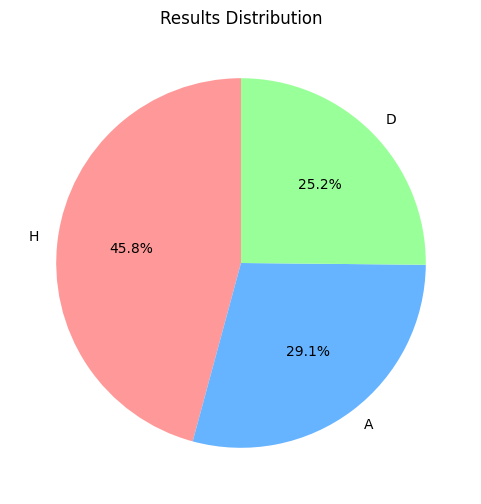

In [270]:
# pie char of results

results = matches['result'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(results, labels=results.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Results Distribution')
plt.show()

In [306]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# wins = matches[matches['result'] == 'H'].sample(n = 600)
# draws = matches[matches['result'] == 'D'].sample(n = 600)
# losses = matches[matches['result'] == 'A'].sample(n = 600)

# df = pd.concat([wins, draws, losses])

df = matches.copy()

for col in ['home_team_prev_mv_graph_1', 'away_team_prev_mv_graph_1', 'home_team_prev_attack_graph_1', 'away_team_prev_attack_graph_1',
            'home_team_prev_mv_graph_2', 'away_team_prev_mv_graph_2', 'home_team_prev_attack_graph_2', 'away_team_prev_attack_graph_2', 
            'home_team_prev_mv_graph_3', 'away_team_prev_mv_graph_3', 'home_team_prev_attack_graph_3', 'away_team_prev_attack_graph_3'
          ]:
    df[col] = df[col].apply(np.array)

# Encode categorical variable 'result'
le = LabelEncoder()
df['result'] = le.fit_transform(df['result'])

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['home_team_prev_mv_graph_1', 'away_team_prev_mv_graph_1', 'home_team_prev_attack_graph_1', 'away_team_prev_attack_graph_1',
                  'home_team_prev_mv_graph_2', 'away_team_prev_mv_graph_2', 'home_team_prev_attack_graph_2', 'away_team_prev_attack_graph_2',
                  'home_team_prev_mv_graph_3', 'away_team_prev_mv_graph_3', 'home_team_prev_attack_graph_3', 'away_team_prev_attack_graph_3'
                  ]
for col in numerical_cols:
  df[col] = df[col].apply(lambda x: scaler.fit_transform(x.reshape(-1,1)).flatten())


# Convert to tensors
X = torch.tensor(np.array([np.concatenate((
    df['home_team_prev_mv_graph_1'].iloc[i], df['away_team_prev_mv_graph_1'].iloc[i],
    df['home_team_prev_attack_graph_1'].iloc[i], df['away_team_prev_attack_graph_1'].iloc[i],
    df['home_team_prev_mv_graph_2'].iloc[i], df['away_team_prev_mv_graph_2'].iloc[i],
    df['home_team_prev_attack_graph_2'].iloc[i], df['away_team_prev_attack_graph_2'].iloc[i],
    df['home_team_prev_mv_graph_3'].iloc[i], df['away_team_prev_mv_graph_3'].iloc[i],
    df['home_team_prev_attack_graph_3'].iloc[i], df['away_team_prev_attack_graph_3'].iloc[i]
)) for i in range(len(df))]), dtype=torch.float32)

y = torch.tensor(df['result'].values, dtype=torch.long) 

In [313]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Modified MLP Model ---
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.10) #19% dropout
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        # self.dropout2 = nn.Dropout(0.10)
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        # self.dropout3 = nn.Dropout(0.10)
        self.fc4 = nn.Linear(32, 16)
        self.relu4 = nn.ReLU()
        # self.dropout4 = nn.Dropout(0.10)
        self.fc5 = nn.Linear(16, 8)
        self.relu5 = nn.ReLU()
        # self.dropout5 = nn.Dropout(0.10)
        self.fc6 = nn.Linear(8, 4)
        self.relu6 = nn.ReLU()
        # self.dropout6 = nn.Dropout(0.10)
        self.fc7 = nn.Linear(4, output_size) # Output layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        # out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        # out = self.dropout3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        # out = self.dropout4(out)
        out = self.fc5(out)
        out = self.relu5(out)
        # out = self.dropout5(out)
        out = self.fc6(out)
        out = self.relu6(out)
        # out = self.dropout6(out)
        out = self.fc7(out) #No activation on output layer for multi-class classification.
        return out

# Hyperparameters
input_size = X.shape[1]  #adjust input size based on length of your concatenated feature vector
hidden_size = 64
output_size = len(le.classes_) # Number of unique result classes
learning_rate = 0.01
num_epochs = 200

# Initialize model, optimizer, and loss function
model = MLP(input_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# --- Training ---

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# --- Evaluation ---

with torch.no_grad():
    predicted = model(X_test)
    _, predicted_classes = torch.max(predicted, 1)
    accuracy = (predicted_classes == y_test).sum().item() / len(y_test)
    print(f'Test Accuracy: {accuracy:.4f}')

Epoch [50/200], Loss: 0.5498
Epoch [100/200], Loss: 0.2291
Epoch [150/200], Loss: 0.1412
Epoch [200/200], Loss: 0.1362
Test Accuracy: 0.3282


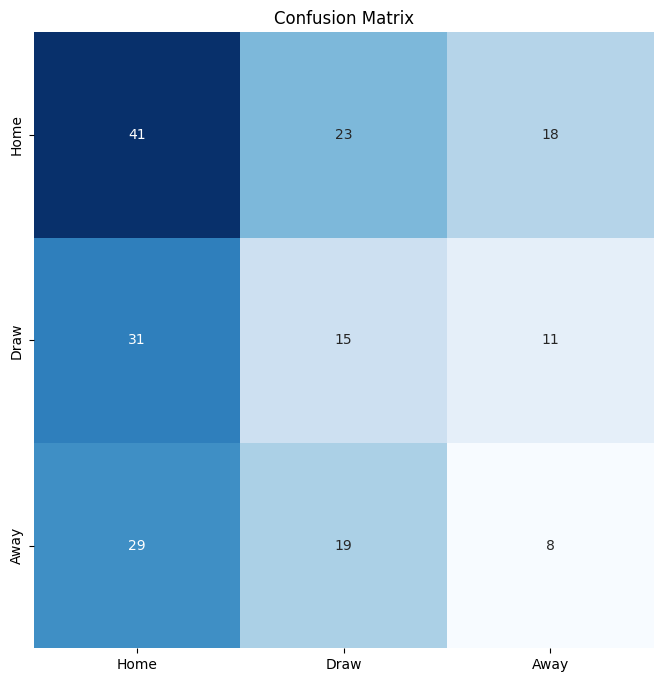

In [315]:
confusion_matrix = pd.crosstab(y_test, predicted_classes, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix = confusion_matrix.to_numpy()[::-1, ::-1]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Home', 'Draw', 'Away'], yticklabels=['Home', 'Draw', 'Away'], cbar= False)
plt.title('Confusion Matrix')
plt.show()

In [285]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# ... (Your data loading, preprocessing, and model training code) ...


with torch.no_grad():
    predicted = model(X_test)
    _, predicted_classes = torch.max(predicted, 1)
    predicted_classes = predicted_classes.numpy()

#Get unique classes as strings (this is crucial)
unique_classes = list(map(str, np.unique(df['result']))) #Convert unique integer classes to strings
# Alternatively, if you know the classes beforehand:
# unique_classes = ['Home', 'Away', 'Draw']  # Replace with your actual class names

print(classification_report(y_test, predicted_classes, target_names=unique_classes))

              precision    recall  f1-score   support

           0       0.34      0.57      0.43        56
           1       0.24      0.14      0.18        57
           2       0.53      0.44      0.48        82

    accuracy                           0.39       195
   macro avg       0.37      0.38      0.36       195
weighted avg       0.39      0.39      0.38       195



In [339]:
import pandas as pd
import torch
from torch_geometric.data import Data
import numpy as np

# for each match, create 3 previous matches of each team, somehow unite them in a single graph and predict the result of the match do as PyG data object


home_team_prev_graphs = ['home_team_prev_mv_graph_1', 'home_team_prev_attack_graph_1', 'home_team_prev_mv_graph_2', 'home_team_prev_attack_graph_2', 'home_team_prev_mv_graph_3', 'home_team_prev_attack_graph_3']
away_team_prev_graphs = ['away_team_prev_mv_graph_1', 'away_team_prev_attack_graph_1', 'away_team_prev_mv_graph_2', 'away_team_prev_attack_graph_2', 'away_team_prev_mv_graph_3', 'away_team_prev_attack_graph_3']


r = matches.iloc[0]

home_team_graph_sum = nx.DiGraph()

for col in home_team_prev_graphs:
     home_team_graph_sum = nx.compose(home_team_graph_sum, r[col])

away_team_graph_sum = nx.DiGraph()

for col in away_team_prev_graphs:

     away_team_graph_sum = nx.compose(away_team_graph_sum, r[col])



home_team_graph_sum = nx.relabel_nodes(home_team_graph_sum, {node: f'home_{node}' for node in home_team_graph_sum.nodes()})
away_team_graph_sum = nx.relabel_nodes(away_team_graph_sum, {node: f'away_{node}' for node in away_team_graph_sum.nodes()})

G = nx.compose(home_team_graph_sum, away_team_graph_sum)

for node in G.nodes:
    G.nodes[node]['features'] = [G.out_degree(node)]  # Single feature: out-degree

# Prepare node features for PyG Data
x = torch.tensor(
    np.array([
        G.nodes[node].get('features', [0])  # Default to [0] if no features are present
        for node in G.nodes
    ]),
    dtype=torch.float32
)

# Prepare edge indices
edge_index = torch.tensor(
    [[list(G.nodes).index(edge[0]), list(G.nodes).index(edge[1])] for edge in G.edges],
    dtype=torch.long
).t().contiguous()

# Prepare target variable
# result = "draw"

y = r['result']

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)

print(data)

Data(x=[30, 1], edge_index=[2, 450], y='D')
